# Demo Import from Sklearn with Schemas from Lale

This notebook shows how to use Lale directly with sklearn operators.
The function `lale.wrap_imported_operators()` will automatically wrap
known sklearn operators into Lale operators.

## Usability

To make Lale easy to learn and use, its APIs imitate those of
[sklearn](https://scikit-learn.org/), with init, fit, and predict,
and with pipelines.

In [1]:
import sklearn.datasets
import sklearn.model_selection
digits = sklearn.datasets.load_digits()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42)
print(f'truth  {y_test.tolist()[:20]}')

truth  [6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8]


In [2]:
import lale
from sklearn.linear_model import LogisticRegression as LR
lale.wrap_imported_operators()

trainable_lr = LR(LR.solver.lbfgs, C=0.0001)
trained_lr = trainable_lr.fit(X_train, y_train)
predictions = trained_lr.predict(X_test)
print(f'actual {predictions.tolist()[:20]}')

actual [6, 9, 3, 7, 2, 2, 5, 2, 5, 2, 1, 4, 4, 0, 4, 2, 3, 7, 8, 8]


In [3]:
from sklearn.metrics import accuracy_score
print(f'accuracy {accuracy_score(y_test, predictions):.1%}')

accuracy 91.7%


## Correctness

Lale uses [JSON Schema](https://json-schema.org/) to check for valid
hyperparameters. These schemas enable not just validation but also
interactive documentation. Thanks to using a single source of truth, the
documentation is correct by construction.

In [4]:
from jsonschema import ValidationError
try:
    lale_lr = LR(solver='adam', C=0.01)
except ValidationError as e:
    print(e.message)

Invalid configuration for LR(solver='adam', C=0.01) due to invalid value solver=adam.
Schema of argument solver: {
    'description': 'Algorithm for optimization problem.',
    'enum': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'default': 'liblinear'}
Value: adam


In [5]:
LR.hyperparam_schema('C')

{'description': 'Inverse regularization strength. Smaller values specify stronger regularization.',
 'type': 'number',
 'distribution': 'loguniform',
 'minimum': 0.0,
 'exclusiveMinimum': True,
 'default': 1.0,
 'minimumForOptimizer': 0.03125,
 'maximumForOptimizer': 32768}

In [6]:
LR.hyperparam_defaults()

{'solver': 'liblinear',
 'penalty': 'l2',
 'dual': False,
 'C': 1.0,
 'tol': 0.0001,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'class_weight': None,
 'random_state': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None}

## Automation

Lale includes a compiler that converts types (expressed as JSON
Schema) to optimizer search spaces. It currently has back-ends for
[hyperopt](http://hyperopt.github.io/hyperopt/),
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), and
[SMAC](http://www.automl.org/smac/).
We are also actively working towards various other forms of AI
automation using various other tools.

In [7]:
from lale.search.op2hp import hyperopt_search_space
from hyperopt import STATUS_OK, Trials, fmin, tpe, space_eval
import lale.helpers
import warnings
warnings.filterwarnings("ignore")

def objective(hyperparams):
    trainable = LR(**lale.helpers.dict_without(hyperparams, 'name'))
    trained = trainable.fit(X_train, y_train)
    predictions = trained.predict(X_test)
    return {'loss': -accuracy_score(y_test, predictions), 'status': STATUS_OK}

search_space = hyperopt_search_space(LR)

trials = Trials()
fmin(objective, search_space, algo=tpe.suggest, max_evals=10, trials=trials)
best_hps = space_eval(search_space, trials.argmin)
print(f'best hyperparams {lale.helpers.dict_without(best_hps, "name")}\n')
print(f'accuracy {-min(trials.losses()):.1%}')

100%|██████████| 10/10 [00:04<00:00,  2.09it/s, best loss: -0.9722222222222222]
best hyperparams {'C': 15997.761599576745, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.06153106088019582}

accuracy 97.2%


## Composition

Lale supports composite models, which resemble sklearn pipelines but are
more expressive.

| Symbol | Name | Description  | Sklearn feature |
| ------ | ---- | ------------ | --------------- |
| >>     | pipe | Feed to next | `make_pipeline` |
| &      | and  | Run both     | `make_union`, includes concat |
| &#x7c; | or   | Choose one   | (missing) |

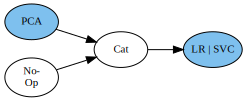

In [8]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from lale.lib.lale import ConcatFeatures as Cat
from lale.lib.lale import NoOp
lale.wrap_imported_operators()

optimizable = (PCA & NoOp) >> Cat >> (LR | SVC)
lale.helpers.to_graphviz(optimizable)

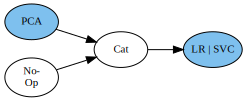

In [9]:
from lale.operators import make_pipeline, make_union, make_choice
optimizable = make_pipeline(make_union(PCA, NoOp), make_choice(LR, SVC))
lale.helpers.to_graphviz(optimizable)

In [10]:
import lale.lib.lale.hyperopt_classifier
import logging
lale.lib.lale.hyperopt_classifier.logger.setLevel(logging.ERROR)
Optimizer = lale.lib.lale.hyperopt_classifier.HyperoptClassifier
optimizer = Optimizer(estimator=optimizable, max_evals=10)
trained = optimizer.fit(X_train, y_train)

100%|██████████| 10/10 [00:50<00:00,  5.16s/it, best loss: -0.9902556438206324]


accuracy 98.9%


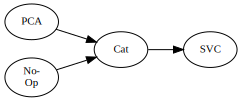

In [11]:
predictions = trained.predict(X_test)
print(f'accuracy {accuracy_score(y_test, predictions):.1%}')
lale.helpers.to_graphviz(lale.helpers.best_estimator(trained))

## Input and Output Schemas

Besides schemas for hyperparameter, Lale also provides operator tags
and schemas for input and output data of operators.

In [12]:
LR.get_tags()

{'pre': ['~categoricals'],
 'op': ['estimator', 'classifier', 'interpretable'],
 'post': ['probabilities']}

In [13]:
LR.get_schema('input_fit')

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'description': 'Input data schema for training.',
 'type': 'object',
 'required': ['X', 'y'],
 'additionalProperties': False,
 'properties': {'X': {'description': 'Features; the outer array is over samples.',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'y': {'description': 'Target class labels; the array is over samples.',
   'type': 'array',
   'items': {'type': 'number'}}}}

In [14]:
LR.get_schema('output')

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'description': 'Output data schema for predictions (target class labels).',
 'anyOf': [{'description': 'For predict, class label.',
   'type': 'array',
   'items': {'type': 'number'}},
  {'description': 'For predict_proba, for each sample, vector of probabilities.',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}}]}